In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class RigidBodyCalibration:
    def __init__(self):
        self.R = np.eye(3)
        self.t = np.zeros((3, 1))
        self.T = np.eye(4)

    def load_csv(self, file_path):
        """
        读取包含 pointx, pointy, pointz (动捕) 和 toolx, tooly, toolz (机械臂) 的CSV
        """
        try:
            # 自动处理空格和大小写
            df = pd.read_csv(file_path, skipinitialspace=True)
            df.columns = df.columns.str.strip().str.lower()
            
            # 检查列名
            required_mocap = ['pointx', 'pointy', 'pointz']
            required_tool = ['toolx', 'tooly', 'toolz']
            
            if not all(col in df.columns for col in required_mocap + required_tool):
                raise ValueError(f"CSV缺少必要的列。需要: {required_mocap + required_tool}")

            # 提取数据 (N, 3)
            pts_mocap = df[required_mocap].to_numpy()
            pts_robot = df[required_tool].to_numpy()

            # 单位转换
            # pts_mocap /= 1000.0  # mm 转 m
            # pts_robot /= 1000.0  # mm 转 m

            print(f"成功加载 {len(pts_mocap)} 组数据点")
            return pts_mocap, pts_robot
            
        except Exception as e:
            print(f"读取文件失败: {e}")
            return None, None

    def solve_svd(self, source_points, target_points):
        """
        核心算法：使用 SVD 求解刚体变换
        目标：Target = R * Source + t
        这里: Mocap = R * Robot + t
        """
        assert len(source_points) == len(target_points)
        
        # 1. 计算质心
        centroid_src = np.mean(source_points, axis=0) # Robot中心
        centroid_tgt = np.mean(target_points, axis=0) # Mocap中心
        
        # 2. 去中心化
        src_centered = source_points - centroid_src
        tgt_centered = target_points - centroid_tgt
        
        # 3. 计算协方差矩阵 H
        H = src_centered.T @ tgt_centered
        
        # 4. SVD 分解
        U, S, Vt = np.linalg.svd(H)
        
        # 5. 计算旋转矩阵 R
        R_est = Vt.T @ U.T
        
        # 6. 处理反射情况 (行列式为-1时说明算成了镜像)
        if np.linalg.det(R_est) < 0:
            Vt[-1, :] *= -1
            R_est = Vt.T @ U.T
            
        # 7. 计算平移向量 t
        t_est = centroid_tgt - R_est @ centroid_src
        
        # 保存结果
        self.R = R_est
        self.t = t_est.reshape(3, 1)
        
        self.T = np.eye(4)
        self.T[:3, :3] = self.R
        self.T[:3, 3] = self.t.flatten()
        
        return self.T

    def evaluate(self, pts_robot, pts_mocap):
        """
        计算 RMSE 误差
        """
        pts_robot_h = np.hstack((pts_robot, np.ones((len(pts_robot), 1)))) # 齐次坐标
        pts_transformed = (self.T @ pts_robot_h.T).T[:, :3]
        
        # 计算每个点的欧氏距离误差
        errors = np.linalg.norm(pts_transformed - pts_mocap, axis=1)
        rmse = np.sqrt(np.mean(errors**2))
        
        return rmse, errors, pts_transformed

    def visualize(self, pts_robot, pts_mocap, pts_transformed):
        """
        可视化对比：原始位置 vs 变换后位置 vs 目标位置
        """
        fig = plt.figure(figsize=(12, 6))
        
        # 视角 1
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.set_title("Before Calibration (Robot vs Mocap)")
        ax1.scatter(pts_robot[:,0], pts_robot[:,1], pts_robot[:,2], c='blue', marker='^', label='Robot Raw')
        ax1.scatter(pts_mocap[:,0], pts_mocap[:,1], pts_mocap[:,2], c='red', marker='o', label='Mocap Target')
        ax1.legend()
        
        # 视角 2 (结果)
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.set_title("After Calibration (Aligned)")
        ax2.scatter(pts_transformed[:,0], pts_transformed[:,1], pts_transformed[:,2], c='green', marker='^', label='Robot Transformed')
        ax2.scatter(pts_mocap[:,0], pts_mocap[:,1], pts_mocap[:,2], c='red', marker='o', label='Mocap Target')
        
        # 画误差线
        for i in range(len(pts_mocap)):
            ax2.plot([pts_transformed[i,0], pts_mocap[i,0]],
                     [pts_transformed[i,1], pts_mocap[i,1]],
                     [pts_transformed[i,2], pts_mocap[i,2]], 'gray', linestyle='--', alpha=0.5)
            
        ax2.legend()
        plt.tight_layout()
        plt.show()

成功加载 4 组数据点

正在执行 SVD 配准...
----------------------------------------
标定结果 T (Robot Base -> Mocap):
[[ 0.9995  0.0322  0.0036 -0.4882]
 [-0.0323  0.9994  0.0119  1.7214]
 [-0.0032 -0.012   0.9999  0.7442]
 [ 0.      0.      0.      1.    ]]
----------------------------------------
平移向量 (x, y, z): [-0.4882  1.7214  0.7442]
平均均方根误差 (RMSE): 0.0005 m
最大单点误差: 0.0008 m


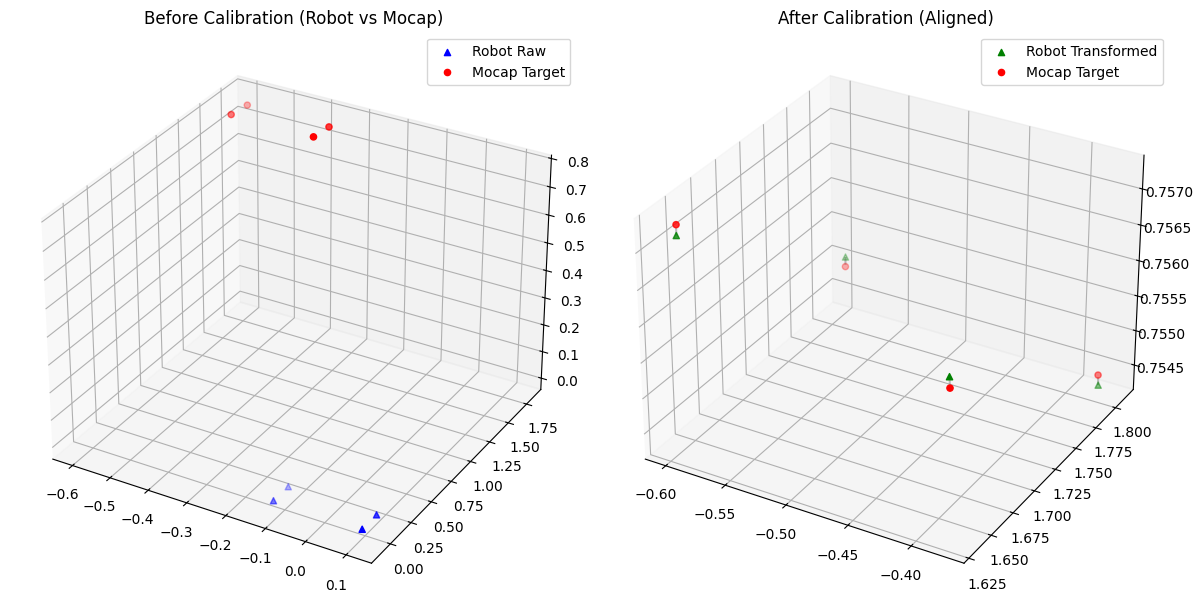

矩阵已保存至 T_robot_to_mocap.txt


In [3]:
if __name__ == "__main__":
    CSV_FILE = "/home/lgx/Project/AFP/src/il_capture/data/calib_model_nokov.csv"
    
    # 1. 生成测试数据 (如果你有真实文件，可以注释掉这行)
    # create_dummy_csv(CSV_FILE)
    
    # 2. 初始化
    calib = RigidBodyCalibration()
    
    # 3. 读取数据
    # Mocap点 (Target), Robot点 (Source)
    pts_mocap, pts_robot = calib.load_csv(CSV_FILE)
    
    if pts_mocap is not None:
        print("\n正在执行 SVD 配准...")
        
        # 4. 计算变换矩阵 T_mocap_base
        # 公式: P_mocap = T * P_robot
        T_result = calib.solve_svd(pts_robot, pts_mocap)
        
        # 5. 评估结果
        rmse, errors, pts_trans = calib.evaluate(pts_robot, pts_mocap)
        
        print("-" * 40)
        print("标定结果 T (Robot Base -> Mocap):")
        np.set_printoptions(suppress=True, precision=4)
        print(T_result)
        print("-" * 40)
        print(f"平移向量 (x, y, z): {T_result[:3, 3]}")
        print(f"平均均方根误差 (RMSE): {rmse:.4f} m")
        print(f"最大单点误差: {np.max(errors):.4f} m")
        
        # 6. 可视化
        calib.visualize(pts_robot, pts_mocap, pts_trans)
        
        # 7. 保存矩阵
        np.savetxt("T_robot_to_mocap.txt", T_result, fmt='%.6f')
        print("矩阵已保存至 T_robot_to_mocap.txt")

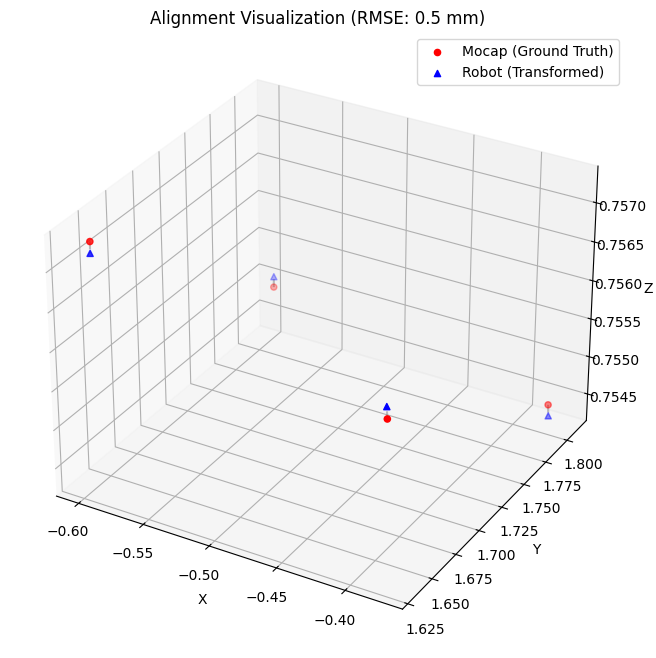

In [4]:
import matplotlib.pyplot as plt

def visualize_errors(T_pred, pts_robot, pts_mocap):
    # 1. 将机械臂的点变换到动捕坐标系下
    # T_pred 是 4x4 矩阵，pts_robot 是 Nx3
    # 变成齐次坐标 Nx4
    ones = np.ones((pts_robot.shape[0], 1))
    pts_robot_h = np.hstack([pts_robot, ones])
    
    # 应用变换: (T @ P.T).T
    pts_robot_transformed = (T_pred @ pts_robot_h.T).T[:, :3]
    
    # 2. 绘图
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 画动捕的点 (红色)
    ax.scatter(pts_mocap[:,0], pts_mocap[:,1], pts_mocap[:,2], c='r', marker='o', label='Mocap (Ground Truth)')
    
    # 画变换后的机械臂点 (蓝色)
    ax.scatter(pts_robot_transformed[:,0], pts_robot_transformed[:,1], pts_robot_transformed[:,2], c='b', marker='^', label='Robot (Transformed)')
    
    # 画连线（误差线）
    for i in range(len(pts_mocap)):
        x_pair = [pts_mocap[i,0], pts_robot_transformed[i,0]]
        y_pair = [pts_mocap[i,1], pts_robot_transformed[i,1]]
        z_pair = [pts_mocap[i,2], pts_robot_transformed[i,2]]
        ax.plot(x_pair, y_pair, z_pair, 'gray', linestyle='--', alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title(f"Alignment Visualization (RMSE: {rmse*1000:.1f} mm)")
    plt.show()

# 在你的主程序最后调用这个函数：
visualize_errors(T_result, pts_robot, pts_mocap)

In [5]:
import yaml
from scipy.spatial.transform import Rotation as R

def save_to_yaml(T_matrix, filename="calibration_result.yaml"):
    """
    将 4x4 变换矩阵保存为 YAML 文件
    包含：平移(xyz)、四元数(xyzw)、原始矩阵
    """
    # 1. 提取平移向量
    translation = T_matrix[:3, 3]
    
    # 2. 提取旋转矩阵并转为四元数 (x, y, z, w)
    rotation_matrix = T_matrix[:3, :3]
    r = R.from_matrix(rotation_matrix)
    quat = r.as_quat() # 返回格式通常是 [x, y, z, w]
    
    # 3. 构造字典 (注意：必须将 numpy 类型转为 python float，否则 yaml 会报错)
    data = {
        "calibration_info": {
            "source_frame": "robot_base",
            "target_frame": "mocap_world",
            "units": "meters"
        },
        "transform": {
            "translation": {
                "x": float(translation[0]),
                "y": float(translation[1]),
                "z": float(translation[2])
            },
            "rotation_quaternion": {
                "x": float(quat[0]),
                "y": float(quat[1]),
                "z": float(quat[2]),
                "w": float(quat[3])
            },
            "rpy_deg": { # 方便肉眼检查的欧拉角
                "roll": float(r.as_euler('xyz', degrees=True)[0]),
                "pitch": float(r.as_euler('xyz', degrees=True)[1]),
                "yaw": float(r.as_euler('xyz', degrees=True)[2])
            }
        },
        # 同时也保存原始矩阵，方便程序直接加载使用
        "homogeneous_matrix": T_matrix.tolist()
    }
    
    # 4. 写入文件
    with open(filename, 'w') as f:
        # default_flow_style=False 让 YAML 格式更易读（分行显示）
        yaml.dump(data, f, default_flow_style=False, sort_keys=False)
    
    print(f"标定结果已成功保存至: {filename}")

# ==========================================
# 在你的主程序 (if __name__ == "__main__":) 最后加入这一行：
# ==========================================

# 假设 T_result 是你刚刚算出来的 4x4 矩阵
if 'T_result' in locals():
    save_to_yaml(T_result, "robot_mocap_transform.yaml")

标定结果已成功保存至: robot_mocap_transform.yaml
